In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparapy as sp
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib ipympl

In [2]:
X = 5
Y = 6
Z = 4
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18

absorption = 0.1
S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [2, 3, 2]
## new approach
radi = sp.radiosity.Radiosity(
    walls, patch_size, max_order_k, ir_length_s,
    speed_of_sound=speed_of_sound, sampling_rate=sampling_rate)

radi_new = sp.DRadiosityFast.from_polygon(walls, patch_size)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

radi_new.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)
radi_new.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))
radi_new.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))

reverberation distance is 0.5426201661567753m
reverberation time is 1.228475783983933s


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_43919/2455019549.py:36: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi_new.set_wall_scattering(


In [3]:
# run simulation
radi.run(source)


100%|██████████| 150/150 [12:34<00:00,  5.03s/it]


In [4]:
# test energy at receiver
receiver = sp.geometry.Receiver(receiver_pos, [0, 1, 0], [0, 0, 1])
ir_nindi = radi.energy_at_receiver(receiver, ignore_direct=True)


In [5]:
radi_new.bake_geometry(algorithm='order')


In [6]:
radi_new.init_source_energy(source_pos, algorithm='order')


In [7]:

ir_order = radi_new.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)


In [8]:

reverberation_nindi = pf.Signal(ir_nindi, sampling_rate=sampling_rate)
reverberation_order = pf.Signal(ir_order, sampling_rate=sampling_rate)

In [9]:

E_reverb_analytical = 4/A


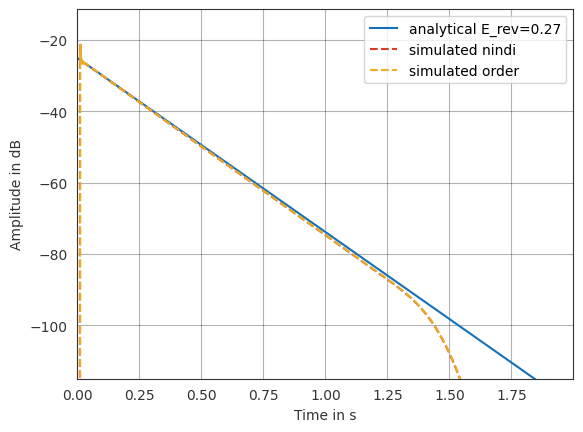

In [11]:
t = reverberation_nindi.times
w_0 = E_reverb_analytical/ V # Kuttruff Eq 4.7
t_0 = 0.03
reverberation_analytic = w_0 * np.exp(+(speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0)) # Kuttruff Eq 4.10
reverberation_analytic = pf.Signal(reverberation_analytic, sampling_rate=sampling_rate)
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')
pf.plot.time(
    reverberation_nindi, dB=True, log_prefix=10,
    label='simulated nindi',
    linestyle='--')
pf.plot.time(
    reverberation_order, dB=True, log_prefix=10,
    label='simulated order',
    linestyle='--')

plt.legend()
plt.show()